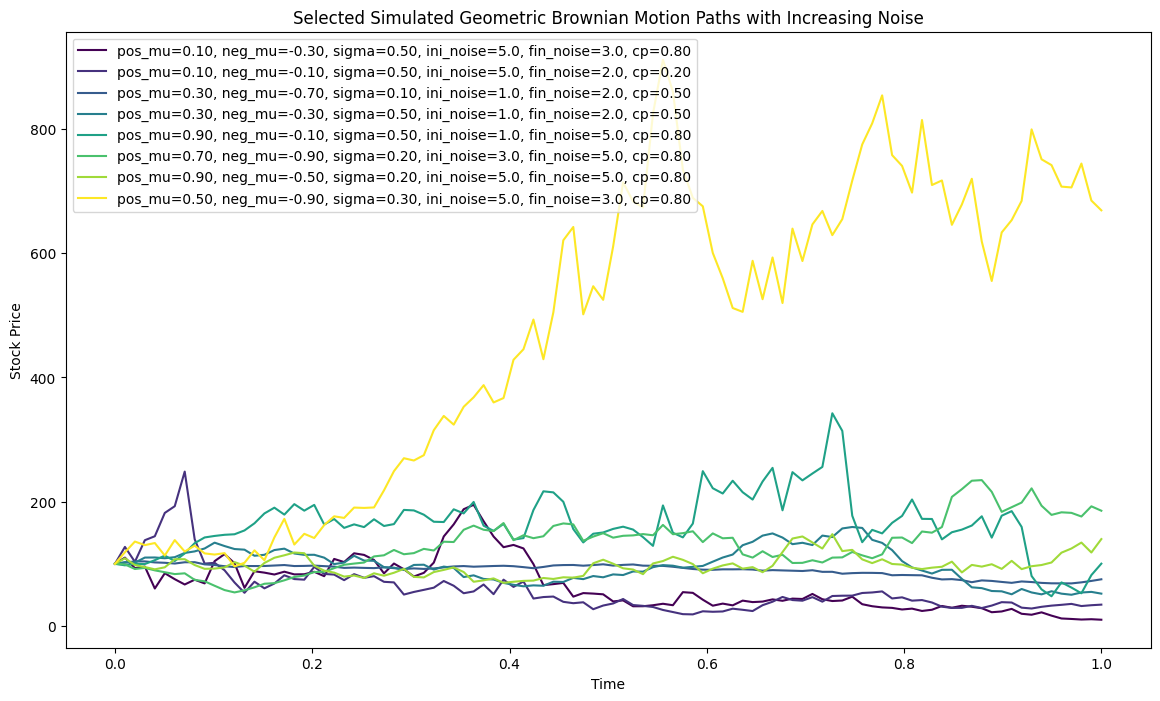

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import random

def simulate_gbm_with_increasing_noise(S0, pos_mu, neg_mu, sigma, T, dt, n_paths, initial_noise_factors, final_noise_factors, change_points, all_combinations=True, sample_size=10, seed=None):
    """
    Simulate multiple paths of Geometric Brownian Motion with increasing noise and a change point for mu.

    Parameters:
    S0 (float): Initial stock price
    pos_mu (list): List of positive drift rates
    neg_mu (list): List of negative drift rates
    sigma (list): List of volatility rates
    T (float): Total time (in years)
    dt (float): Time step
    n_paths (int): Number of paths to simulate
    initial_noise_factors (list): List of initial noise factors
    final_noise_factors (list): List of final noise factors
    change_points (list): List of change points (as a fraction of total time T)
    all_combinations (bool): If True, simulate all possible combinations. If False, use sample_size to sample combinations.
    sample_size (int): Number of random combinations to sample if all_combinations is False
    seed (int, optional): Random seed for reproducibility

    Returns:
    tuple: (time_grid, paths, selected_combinations) where time_grid is a numpy array, paths is a dictionary of simulated paths for each (pos_mu, neg_mu, sigma, initial_noise_factor, final_noise_factor, change_point) pair, and selected_combinations is the list of combinations used for simulation
    """
    if seed is not None:
        np.random.seed(seed)

    n_steps = int(T / dt)
    time_grid = np.linspace(0, T, n_steps)
    paths = {}

    all_combinations_list = list(product(pos_mu, neg_mu, sigma, initial_noise_factors, final_noise_factors, change_points))

    if all_combinations:
        selected_combinations = all_combinations_list
    else:
        selected_combinations = random.sample(all_combinations_list, sample_size)

    for (pos_m, neg_m, s, ini_noise, fin_noise, cp) in selected_combinations:
        S = np.zeros((n_steps, n_paths))
        S[0] = S0

        change_step = int(cp * n_steps)

        for t in range(1, n_steps):
            Z = np.random.standard_normal(n_paths)
            # Linearly interpolate the noise factor over time
            current_noise_factor = ini_noise + (fin_noise - ini_noise) * (t / n_steps)
            current_mu = pos_m if t < change_step else neg_m
            S[t] = S[t-1] * np.exp((current_mu - 0.5 * s**2) * dt + s * np.sqrt(dt) * Z * current_noise_factor)
            
        paths[(pos_m, neg_m, s, ini_noise, fin_noise, cp)] = S

    return time_grid, paths, selected_combinations

def save_simulated_data(time_grid, paths, filename):
    """
    Save the simulated paths to a CSV file.

    Parameters:
    time_grid (array): Array of time points
    paths (dict): Dictionary of simulated paths for each (pos_mu, neg_mu, sigma, initial_noise_factor, final_noise_factor, change_point) pair
    filename (str): Name of the CSV file to save the data
    """
    data = []
    for key, value in paths.items():
        for i in range(value.shape[1]):
            path_data = {'pos_mu': key[0], 'neg_mu': key[1], 'sigma': key[2], 'initial_noise_factor': key[3], 'final_noise_factor': key[4], 'change_point': key[5], 'path': i}
            path_data.update({f't_{t}': value[t, i] for t in range(len(time_grid))})
            data.append(path_data)

    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

def plot_selected_paths(time_grid, paths, selected_pairs):
    """
    Plot selected paths from the simulated data.

    Parameters:
    time_grid (array): Array of time points
    paths (dict): Dictionary of simulated paths for each (pos_mu, neg_mu, sigma, initial_noise_factor, final_noise_factor, change_point) pair
    selected_pairs (list): List of selected pairs (tuples) to plot
    """
    plt.figure(figsize=(14, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_pairs)))

    for color_idx, key in enumerate(selected_pairs):
        value = paths[key]
        plt.plot(time_grid, value[:, 0], color=colors[color_idx], label=f'pos_mu={key[0]:.2f}, neg_mu={key[1]:.2f}, sigma={key[2]:.2f}, ini_noise={key[3]:.1f}, fin_noise={key[4]:.1f}, cp={key[5]:.2f}')

    plt.title('Selected Simulated Geometric Brownian Motion Paths with Increasing Noise')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Parameters
S0 = 100  # Initial stock price
pos_mu = np.round(np.linspace(0.1, 0.9, 5), 2)  # Different positive drift rates generated using linspace and rounded
neg_mu = np.round(np.linspace(-0.9, -0.1, 5), 2)  # Different negative drift rates generated using linspace and rounded
sigma = np.round(np.linspace(0.1, 0.5, 5), 2)  # Different volatility rates generated using linspace and rounded
initial_noise_factors = [1.0, 3 ,5]  # Different initial noise factors
final_noise_factors = [2.0, 3, 5]  # Different final noise factors
change_points = [0.2, 0.5, 0.8]  # Different change points as fractions of T
T = 1.0  # Total time (1 year)
dt = 0.01  # Time step
n_paths = 10  # Number of paths to simulate
seed = 42  # Random seed for reproducibility
sample_size = 100  # Number of random combinations to sample for simulation
plot_sample_size = 8  # Number of random combinations to sample for plotting

# Simulate GBM with increasing noise and change point
time_grid, paths, selected_combinations = simulate_gbm_with_increasing_noise(S0, pos_mu, neg_mu, sigma, T, dt, n_paths, initial_noise_factors, final_noise_factors, change_points, all_combinations=False, sample_size=sample_size, seed=seed)

# Save the simulated data
filename = 'simulated_gbm_paths_with_increasing_noise_and_change_point.csv'
save_simulated_data(time_grid, paths, filename)

# Sample combinations for plotting
selected_selected_combinations = random.sample(selected_combinations, plot_sample_size)

# Plot the selected paths
plot_selected_paths(time_grid, paths, selected_selected_combinations)
